In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass, field

import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython import display

from darts_pro.dqn import (
    DQNTrainingLoop, 
    LinearNetwork,
    StepResult,
    TrainingLoopConfig,
    DQN,
    EpisodeEndPayload
)

In [3]:
env = gym.make("CartPole-v1")

In [17]:
MAX_X = 2.4
MAX_THETA = 0.2095
THETA_SCALE = (np.pi / 2) / MAX_THETA

@dataclass
class CartPoleConfig:
    steps_between_agent_update: int = 5
    loop_config: TrainingLoopConfig = field(default_factory=TrainingLoopConfig)


class CartPoleTrainingLoop(DQNTrainingLoop):
    def __init__(
            self,
            n_episodes: int,
            env: gym.Env,
            policy_network: DQN,
            target_network: DQN,
            config: CartPoleConfig):
        super().__init__(n_episodes, [0, 1], policy_network, target_network, None, config.loop_config)
        self._env = env
        self._steps_between_agent_update = config.steps_between_agent_update
        self._steps = 0

        self._reset_env()


    def _should_increment_agent_strategy(self) -> bool:
        if self._steps > 0 and self._steps % self._steps_between_agent_update == 0:
            self._steps = 0
            return True
        return False
    
    def _current_state(self) -> torch.Tensor:
        return self._current_state_tensor
    
    def _reset_env(self):
        initial_state, _ = self._env.reset()
        self._current_state_tensor = torch.Tensor(initial_state)

    def _reward_for_state(self, state: torch.Tensor) -> float:
        # We should get a 1 if we're perfectly in the middle of the screen
        # with the pole standing perfectly upright. It should approach zero as
        # we move towards the end of the screen or if the pole starts falling over.
        x, _, theta, __ = state
        x_component = 1 - (1 / MAX_X) * np.abs(x)
        theta_component = np.cos(THETA_SCALE * theta)

        # Taking geometric mean here because I want it to fall off to zero if either
        # component is small instead of arithmetic mean.
        return np.sqrt(np.maximum(x_component, 0) * np.maximum(theta_component, 0))

    
    def _step(self, action: int) -> StepResult:
        next_state, _, terminated, truncated, _ = self._env.step(action)
        done = terminated or truncated
        reward = self._reward_for_state(next_state) if not done else -1.0
        self._steps += 1

        next_state_tensor = torch.Tensor(next_state)
        if done:
            self._reset_env()
        else:
            self._current_state_tensor = next_state_tensor
        return next_state_tensor, reward, done, {}


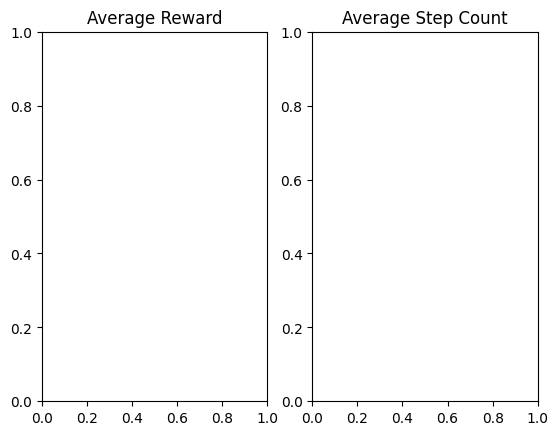

In [18]:
EPISODES_BETWEEN_REPORT = 15
SMOOTH_WINDOW_LENGTH = 5

all_rewards = []
all_step_counts = []

fig, [a1, a2] = plt.subplots(1, 2)
a1.set_title("Average Reward")
a2.set_title("Average Step Count")

def on_episode_end(payload: EpisodeEndPayload):
    all_rewards.append(payload.total_epsisode_reward)
    all_step_counts.append(payload.n_steps)
    if payload.episode_number % EPISODES_BETWEEN_REPORT > 0:
        return

    print(
        f"Finished game {payload.episode_number}. Total Reward for episode {payload.total_epsisode_reward}"
    )

    plt.clf()
    averaged_reward = np.convolve(all_rewards, 1 / SMOOTH_WINDOW_LENGTH * np.ones(SMOOTH_WINDOW_LENGTH))
    averaged_steps = np.convolve(all_step_counts, 1 / SMOOTH_WINDOW_LENGTH * np.ones(SMOOTH_WINDOW_LENGTH))
    if len(averaged_reward) <= 2 * SMOOTH_WINDOW_LENGTH:
        return
    a1.plot(averaged_reward[SMOOTH_WINDOW_LENGTH:-SMOOTH_WINDOW_LENGTH], color="red")
    a2.plot(averaged_steps[SMOOTH_WINDOW_LENGTH:-SMOOTH_WINDOW_LENGTH], color="blue")
    # fig.show()
    display.display(fig)
    display.clear_output(wait=True)


In [19]:
loop_config = TrainingLoopConfig()
conf = CartPoleConfig(steps_between_agent_update=5)
policy_network = LinearNetwork(4, 2, [128, 128])
target_network = LinearNetwork(4, 2, [128, 128])

loop = CartPoleTrainingLoop(300, env, policy_network, target_network, conf)
loop.add_on_episode_end_callback(on_episode_end)

In [20]:
loop.run()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>